# DASC 512 - Week 8 - Regression Examples

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.graphics.api as smg
import statsmodels.formula.api as smf

sns.set_style('darkgrid')

In [2]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    It uses Locally Weighted Scatterplot Smoothing (LOWESS) to fit a model. 
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    pred = model.fittedvalues
    influence = model.get_influence()
    resid_std = influence.resid_studentized_internal
    
    fig, ax = plt.subplots(1,2, figsize=(7.5,3.5))
    
    sns.regplot(x=pred, y=y, lowess=True, ax=ax[0], line_kws={'color':'darkorchid'})
    # I've added the ideal line (y=yhat) for comparison
    sns.lineplot(x=[min(pred), max(pred)], y=[min(pred), max(pred)], 
                 ax=ax[0], color='red', ls=':')
    ax[0].set_title('Observed vs. Predicted Values')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Observed')
    
    sns.regplot(x=pred, y=resid_std, lowess=True, ax=ax[1], line_kws={'color':'darkorchid'})
    # I've added the ideal line (y=0) for comparison
    sns.lineplot(x=[min(pred), max(pred)], y=[0,0], ax=ax[1], color='red', ls=':')
    ax[1].set_title('Residuals vs. Predicted Values')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Standardized Residual')
    
    return fig, ax

## Housing Prices

We'll use sklearn's California House Prices dataset for this. It is a particularly ugly dataset, so perfect for our purposes here. Note: sklearn is now including in the Anaconda package by default, so hopefully you already have it!

In [3]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [4]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [5]:
X = pd.DataFrame(housing.data, columns=housing.feature_names)

In [6]:
X.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [7]:
y = pd.DataFrame(housing.target, columns=housing.target_names)

In [8]:
y.describe()
# Seems to be in $100k

,MedHouseVal
count,20640.000000
mean,2.068558
std,1.153956
min,0.149990
25%,1.196000
50%,1.797000
75%,2.647250
max,5.000010


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

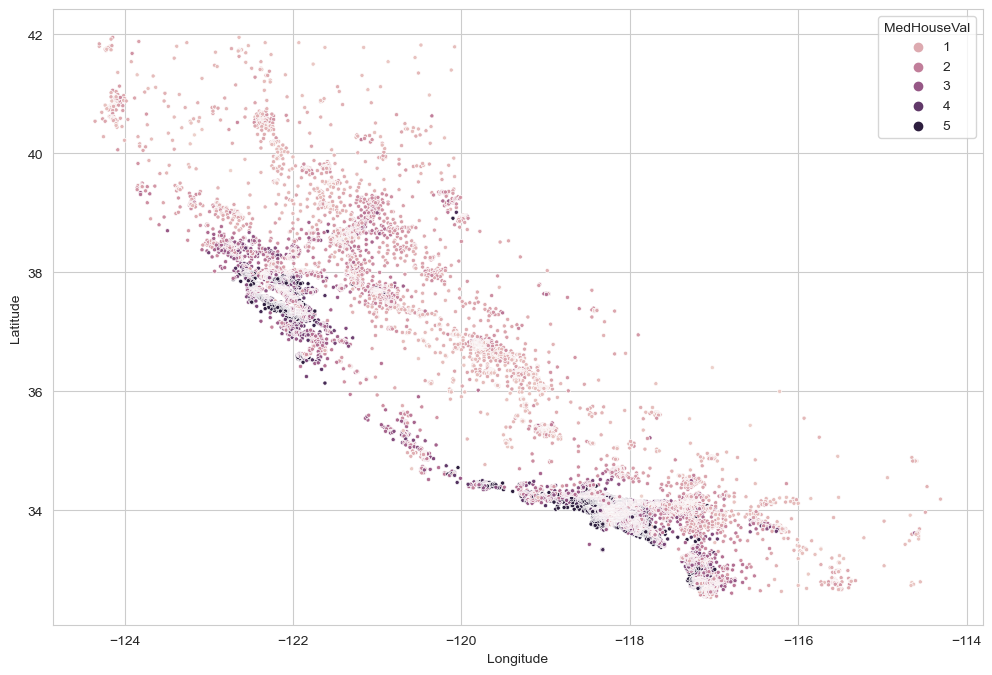

In [9]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x=X['Longitude'], y=X['Latitude'], hue=y['MedHouseVal'], marker='.')

Similar to what we did earlier with Species data, let's start with a full model and examine the residuals to see if we need to do a y-transform. I'll still leave out the lat/long because it could be useful by building new features but it won't be useful in terms of regression without going deep down the rabbit hole of feature generation.

In [10]:
X = X.drop(['Latitude','Longitude'],axis=1)

### Train/Validation/Test Split

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.2, random_state=101)

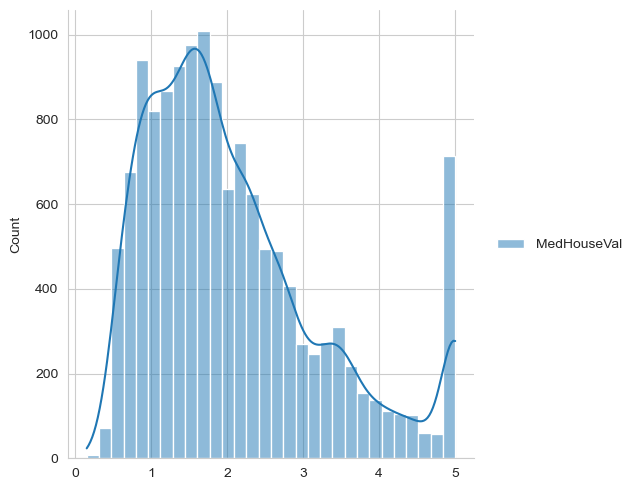

In [13]:
sns.displot(data=y_train, kde=True, bins=30)

There is already an obvious problem here. They have capped the median house value at \\$5M, and obviously it can't have a value below \\$0. Let's press forward and just be aware of these limitations in the data - likely something we can't fully correct for.

In [14]:
formula = 'MedHouseVal ~ MedInc * HouseAge * AveRooms * AveBedrms * Population * AveOccup + I(MedInc**2) + I(HouseAge**2) + I(AveRooms**2) + I(AveBedrms**2) + I(Population**2) + I(AveOccup**2)'
calimodel = smf.ols(formula,X_train.join(y_train)).fit()
calimodel.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Results: Ordinary least squares
=======================================================================================================
Model:                          OLS                          Adj. R-squared:                 0.635     
Dependent Variable:             MedHouseVal                  AIC:                            29333.9778
Date:                           2022-11-21 16:31             BIC:                            29861.3893
No. Observations:               13828                        Log-Likelihood:                 -14597.   
Df Model:                       69                           F-statistic:                    349.5     
Df Residuals:                   13758                        Prob (F-statistic):             0.00      
R-squared:                      0.637                        Scale:                          0.48598   
-------------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                               0.4063   0.6859   0.5923 0.5536 -0.9382  1.7507
MedInc                                                  0.4581   0.1853   2.4728 0.0134  0.0950  0.8212
HouseAge                                                0.0019   0.0275   0.0677 0.9460 -0.0521  0.0558
MedInc:HouseAge                                         0.0090   0.0070   1.2778 0.2013 -0.0048  0.0227
AveRooms                                               -0.7797   0.1052  -7.4106 0.0000 -0.9859 -0.5735
MedInc:AveRooms                                         0.1832   0.0263   6.9722 0.0000  0.1317  0.2347
HouseAge:AveRooms                                       0.0088   0.0034   2.6281 0.0086  0.0022  0.0154
MedInc:HouseAge:AveRooms                               -0.0043   0.0008  -5.6527 0.0000 -0.0058 -0.0028
AveBedrms                                               3.0608   0.5389   5.6794 0.0000  2.0044  4.1171
MedInc:AveBedrms                                       -0.5167   0.1525  -3.3885 0.0007 -0.8156 -0.2178
HouseAge:AveBedrms                                     -0.0525   0.0254  -2.0684 0.0386 -0.1022 -0.0027
MedInc:HouseAge:AveBedrms                               0.0168   0.0062   2.6881 0.0072  0.0045  0.0290
AveRooms:AveBedrms                                     -0.0255   0.0380  -0.6717 0.5018 -0.0999  0.0489
MedInc:AveRooms:AveBedrms                              -0.0171   0.0108  -1.5859 0.1128 -0.0381  0.0040
HouseAge:AveRooms:AveBedrms                             0.0012   0.0015   0.7829 0.4337 -0.0018  0.0042
MedInc:HouseAge:AveRooms:AveBedrms                      0.0001   0.0004   0.2564 0.7976 -0.0008  0.0010
Population                                              0.0020   0.0010   1.9575 0.0503 -0.0000  0.0040
MedInc:Population                                      -0.0010   0.0002  -4.1436 0.0000 -0.0015 -0.0005
HouseAge:Population                                    -0.0000   0.0000  -0.3986 0.6902 -0.0001  0.0001
MedInc:HouseAge:Population                              0.0000   0.0000   0.8473 0.3968 -0.0000  0.0000
AveRooms:Population                                     0.0001   0.0002   0.8588 0.3904 -0.0002  0.0005
MedInc:AveRooms:Population                             -0.0000   0.0000  -0.1128 0.9102 -0.0001  0.0001
HouseAge:AveRooms:Population                           -0.0000   0.0000  -1.6619 0.0965 -0.0000  0.0000
MedInc:HouseAge:AveRooms:Population                     0.0000   0.0000   0.5605 0.5752 -0.0000  0.0000
AveBedrms:Population                                   -0.0021   0.0010  -2.1074 0.0351 -0.0040 -0.0001
MedInc:AveBedrms:Population                             0.0013   0.0003   4.8620 0.0000  0.0008  0.0018
HouseAge:AveBedrms:Population      

Let's look at the residuals.

In [15]:
resid = calimodel.resid
pred = calimodel.fittedvalues

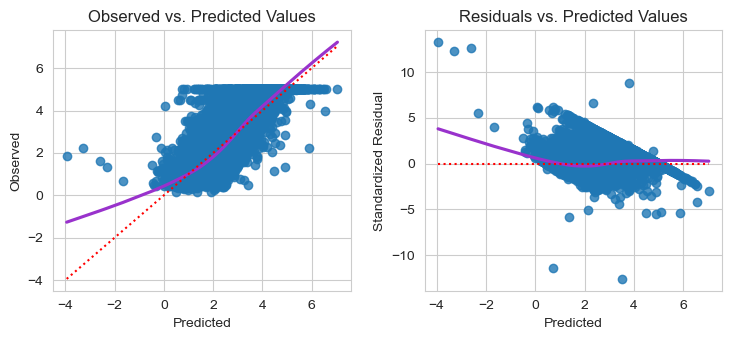

In [16]:
fig, ax = linearity_test(calimodel, y_train)
fig.tight_layout()
plt.show()

There is a very clear problem here of non-constant mean and variance, partially caused by the censoring of the data.

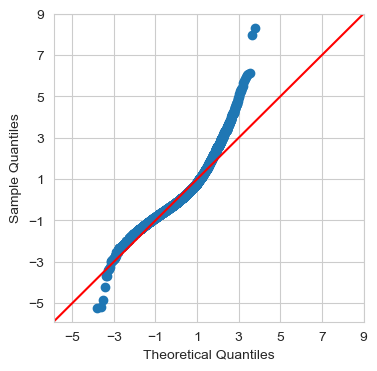

In [17]:
fig, ax = plt.subplots(figsize=(4,4))
smg.qqplot(resid,fit=True,line='45', ax=ax)
ax.set_xticks(np.arange(-5,10,2))
ax.set_yticks(np.arange(-5,10,2))
plt.show()

In [18]:
stats.normaltest(resid)

NormaltestResult(statistic=3092.038272204444, pvalue=0.0)

Normality isn't looking great either. I don't need a test to see that's not normal. Let's try applying a logarithmic transformation to it.

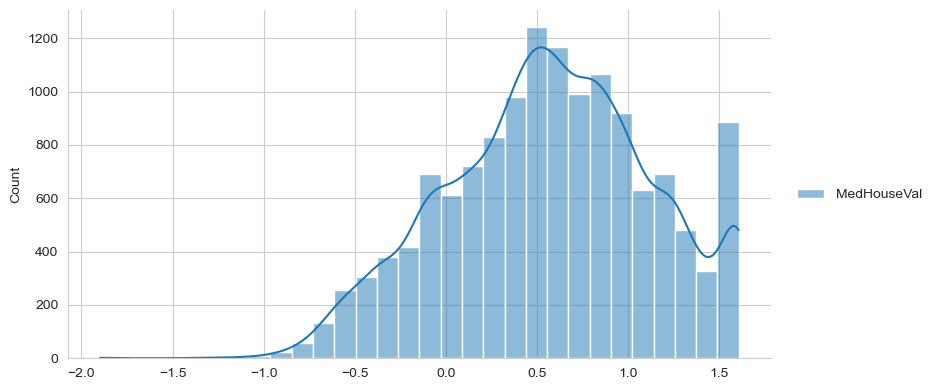

In [19]:
sns.displot(data=y_train.apply(np.log), kde=True, bins=30, height=4, aspect=2)

In [20]:
formula = 'I(np.log(MedHouseVal)) ~ MedInc * HouseAge * AveRooms * AveBedrms * Population * AveOccup + I(MedInc**2) + I(HouseAge**2) + I(AveRooms**2) + I(AveBedrms**2) + I(Population**2) + I(AveOccup**2)'
calimodel = smf.ols(formula,X_train.join(y_train)).fit()
calimodel.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Results: Ordinary least squares
=======================================================================================================
Model:                        OLS                              Adj. R-squared:               0.624     
Dependent Variable:           I(np.log(MedHouseVal))           AIC:                          10107.3457
Date:                         2022-11-21 16:32                 BIC:                          10634.7573
No. Observations:             13828                            Log-Likelihood:               -4983.7   
Df Model:                     69                               F-statistic:                  333.9     
Df Residuals:                 13758                            Prob (F-statistic):           0.00      
R-squared:                    0.626                            Scale:                        0.12100   
-------------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                              -0.9507   0.3422  -2.7778 0.0055 -1.6215 -0.2798
MedInc                                                  0.4737   0.0924   5.1241 0.0000  0.2925  0.6549
HouseAge                                                0.0422   0.0137   3.0729 0.0021  0.0153  0.0691
MedInc:HouseAge                                        -0.0071   0.0035  -2.0207 0.0433 -0.0139 -0.0002
AveRooms                                               -0.1875   0.0525  -3.5712 0.0004 -0.2904 -0.0846
MedInc:AveRooms                                         0.0473   0.0131   3.6118 0.0003  0.0217  0.0730
HouseAge:AveRooms                                      -0.0026   0.0017  -1.5795 0.1142 -0.0059  0.0006
MedInc:HouseAge:AveRooms                               -0.0004   0.0004  -0.9783 0.3279 -0.0011  0.0004
AveBedrms                                               1.4861   0.2689   5.5264 0.0000  0.9590  2.0132
MedInc:AveBedrms                                       -0.2929   0.0761  -3.8492 0.0001 -0.4420 -0.1437
HouseAge:AveBedrms                                     -0.0453   0.0127  -3.5786 0.0003 -0.0701 -0.0205
MedInc:HouseAge:AveBedrms                               0.0140   0.0031   4.4853 0.0000  0.0079  0.0201
AveRooms:AveBedrms                                     -0.0606   0.0189  -3.1957 0.0014 -0.0977 -0.0234
MedInc:AveRooms:AveBedrms                               0.0038   0.0054   0.7019 0.4828 -0.0068  0.0143
HouseAge:AveRooms:AveBedrms                             0.0028   0.0008   3.6622 0.0003  0.0013  0.0043
MedInc:HouseAge:AveRooms:AveBedrms                     -0.0006   0.0002  -2.6881 0.0072 -0.0010 -0.0002
Population                                              0.0001   0.0005   0.1142 0.9091 -0.0009  0.0011
MedInc:Population                                      -0.0002   0.0001  -1.6655 0.0958 -0.0005  0.0000
HouseAge:Population                                     0.0000   0.0000   0.8117 0.4170 -0.0000  0.0001
MedInc:HouseAge:Population                              0.0000   0.0000   0.0161 0.9872 -0.0000  0.0000
AveRooms:Population                                     0.0001   0.0001   1.1485 0.2508 -0.0001  0.0003
MedInc:AveRooms:Population                             -0.0000   0.0000  -0.6880 0.4915 -0.0000  0.0000
HouseAge:AveRooms:Population                           -0.0000   0.0000  -1.3488 0.1774 -0.0000  0.0000
MedInc:HouseAge:AveRooms:Population                    -0.0000   0.0000  -0.1132 0.9099 -0.0000  0.0000
AveBedrms:Population                                   -0.0001   0.0005  -0.1576 0.8748 -0.0010  0.0009
MedInc:AveBedrms:Population                             0.0003   0.0001   2.3396 0.0193  0.0000  0.0006
HouseAge:AveBedrms:Population      

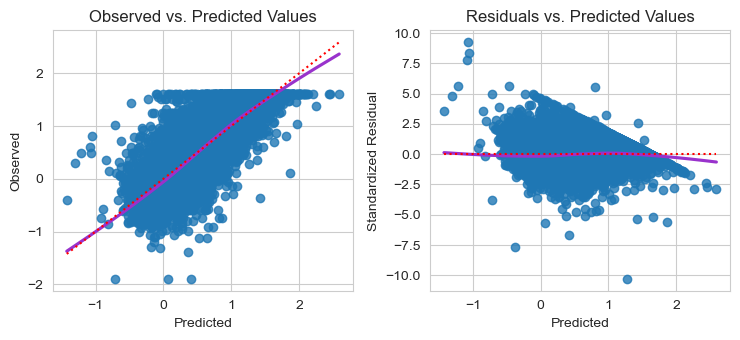

In [21]:
fig, ax = linearity_test(calimodel, y_train.apply(np.log))
fig.tight_layout()
plt.show()

This is a lot better... but honestly it's still pretty ugly. A lot of that is caused by the artificial reporting limitation. The slope is artificially reduced, causing some non-constant mean/variance issues.

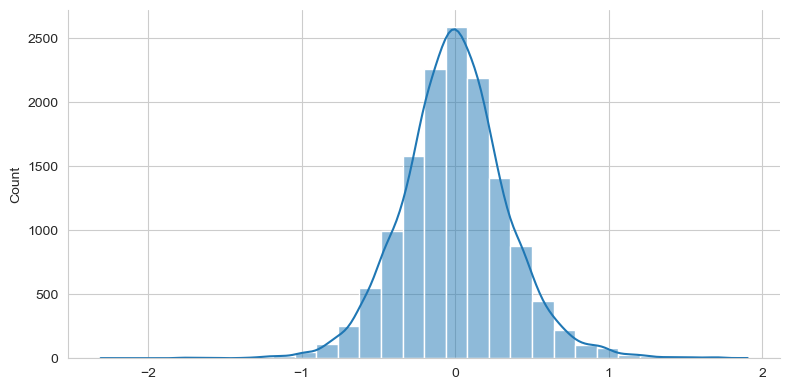

In [22]:
sns.displot(data=calimodel.resid, kde=True, bins=30, height=4, aspect=2)
plt.show()

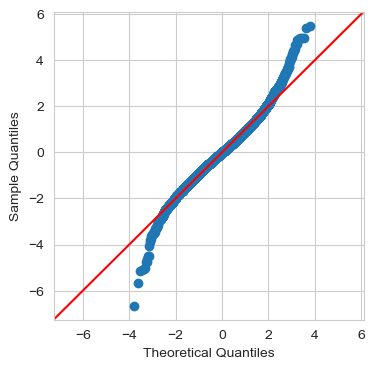

In [23]:
fig, ax = plt.subplots(figsize=(4,4))
smg.qqplot(calimodel.resid, fit=True, line='45', ax=ax)
plt.show()

In [24]:
stats.normaltest(calimodel.resid)

NormaltestResult(statistic=576.9791889686928, pvalue=5.1352433509658614e-126)

Residuals are now unimodal and symmetric, though the distribution has fatter tails than normal. That is, there are more extreme values than would be expected. Again a lot of this is a result of data collection being "right-censored." The slope of prediction would be higher if the data weren't censored, which would result in lower estimates on the low end and higher estimates on the high end, accounting for those fat tails. We'll press ahead with this transformation.

### Model Selection
I included a ludicrous number of terms earlier, all the way up the list of possible interactions. Let's use Lasso to select a reduced model only considering 2nd order terms plus 3-way interactions.

In [25]:
from sklearn.linear_model import Lasso

One thing I don't like about sklearn's PolynomialFeatures function for the purpose of regression --- the column names don't match Patsy. Feel free to take the below functions and apply them instead. Note that it would need to be modified to account for categorical factors (because squaring categorical factors makes no sense, and you'd want the C() wrapper on those).

In [26]:
def poly2(X):
    '''
    Function for adding all second order terms from an X matrix of quantitative factors.
    It creates squared and two-way interaction columns and standardizes them.
    It returns the modified X matrix.
    
    Args:
    * X - the original X matrix

    Returns:
    * A standardized polynomial X matrix with column names matching Patsy formulation
      ensuring that lower-level factors are also included.
    '''
    import scipy.stats as stats
    X_poly = stats.zscore(X.copy())
    for ii in range(len(X.columns)):
        col1 = X.columns[ii]
        X_poly['I(' + col1 + '**2)'] = X_poly[col1] ** 2
        for jj in range(ii+1,len(X.columns)):
            col2 = X.columns[jj]
            X_poly[col1 + '*' + col2] = X_poly[col1] * X_poly[col2]
    return X_poly

In [27]:
def poly3(X):
    '''
    Function for adding all second order terms plus three-way interactions from an X matrix of quantitative factors.
    It creates squared and two/three-way interaction columns and standardizes them.
    It returns the modified X matrix.
    
    Args:
    * X - the original X matrix

    Returns:
    * A standardized polynomial X matrix with column names matching Patsy formulation
      ensuring that lower-level factors are also included.
    '''
    import scipy.stats as stats
    X_poly = stats.zscore(X.copy())
    for ii in range(len(X.columns)):
        col1 = X.columns[ii]
        X_poly['I(' + col1 + '**2)'] = X_poly[col1] ** 2
        for jj in range(ii+1,len(X.columns)):
            col2 = X.columns[jj]
            X_poly[col1 + '*' + col2] = X_poly[col1] * X_poly[col2]
            for kk in range(jj+1, len(X.columns)):
                col3 = X.columns[kk]
                X_poly[col1 + '*' + col2 + '*' + col3] = X_poly[col1]*X_poly[col2]*X_poly[col3]
    return X_poly

In [28]:
X_poly = poly3(X_train)

In [29]:
X_poly.head(1)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,I(MedInc**2),MedInc*HouseAge,MedInc*HouseAge*AveRooms,MedInc*HouseAge*AveBedrms,...,AveRooms*Population,AveRooms*Population*AveOccup,AveRooms*AveOccup,I(AveBedrms**2),AveBedrms*Population,AveBedrms*Population*AveOccup,AveBedrms*AveOccup,I(Population**2),Population*AveOccup,I(AveOccup**2)
5088,-1.5217,-0.758685,-0.918131,0.072769,-0.614962,-0.04015,2.315569,1.15449,-1.059973,0.084011,...,0.564615,-0.022669,0.036863,0.005295,-0.04475,0.001797,-0.002922,0.378178,0.024691,0.001612


Now I'll loop through values of alpha and fit Lasso models to get the coefficients. The more data you have, the lower alpha will tend to be (because SSE grows while the number of betas does not).

In [30]:
coefs = pd.DataFrame(columns=X_poly.columns)
for alpha in np.arange(0.001,0.1,0.001):
    lm = Lasso(alpha=alpha, max_iter=100000)
    lm.fit(X_poly, y_train.apply(np.log))
    coefs.loc[alpha] = lm.coef_

<AxesSubplot:>

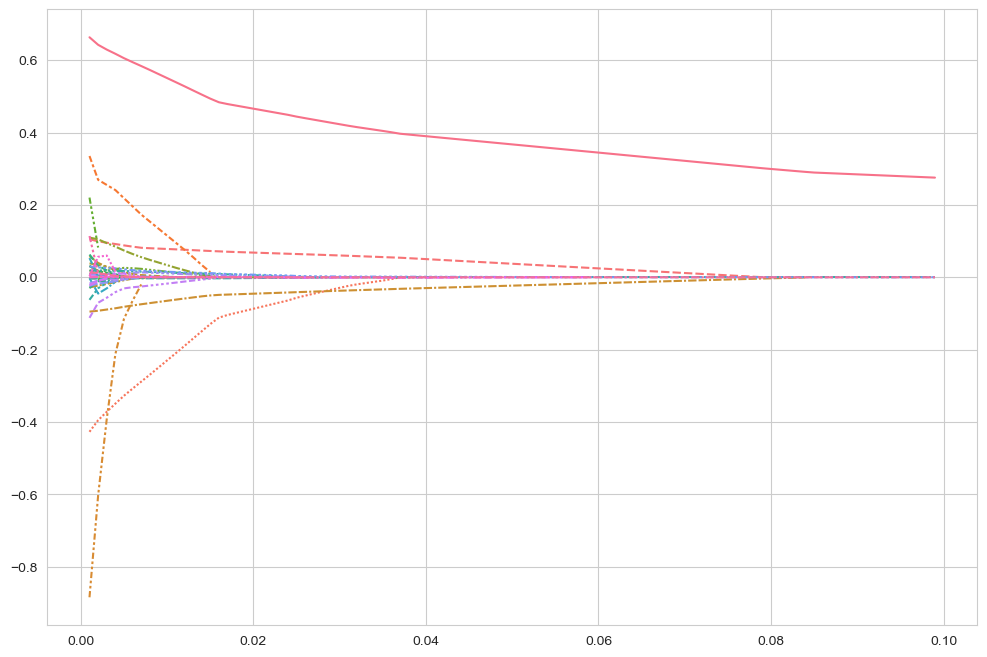

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=coefs[coefs != 0], ax=ax, legend=False)

Let's look at $\alpha=0.025$ as an example.

In [32]:
ii = 24
coefs.iloc[ii][coefs.iloc[ii] != 0] # Due to rounding errors, I use iloc

MedInc                           0.443961
HouseAge                         0.064223
AveRooms                        -0.056741
I(MedInc**2)                    -0.041232
I(HouseAge**2)                   0.001690
HouseAge*AveRooms*AveBedrms     -0.001194
I(AveRooms**2)                   0.003428
AveRooms*AveBedrms*Population    0.000479
I(AveBedrms**2)                 -0.000879
I(Population**2)                 0.000004
I(AveOccup**2)                  -0.000160
Name: 0.025, dtype: float64

In [33]:
def form(ii):
    '''
    Useful only here. Builds a Patsy formula from a column of the coefficient DataFrame.
    '''
    formula = 'I(np.log(MedHouseVal)) ~ '
    for term in coefs.iloc[ii][coefs.iloc[ii] != 0].index:
        formula += term + ' + '
    return formula[:-3]

In [34]:
formula = form(ii)
formula

'I(np.log(MedHouseVal)) ~ MedInc + HouseAge + AveRooms + I(MedInc**2) + I(HouseAge**2) + HouseAge*AveRooms*AveBedrms + I(AveRooms**2) + AveRooms*AveBedrms*Population + I(AveBedrms**2) + I(Population**2) + I(AveOccup**2)'

Now let's consider every alpha we plotted and find the value that generates an OLS model with minimum BIC. You could use another metric for this if you preferred.

In [35]:
# For easier typing...
Xy_train = X_train.join(y_train)

In [36]:
best_ii = 0
best_bic = 9999999
for ii in range(len(coefs)):
    formula = form(ii)
    model = smf.ols(formula, Xy_train).fit()
    if model.bic <= best_bic:
        best_ii = ii
        best_bic = model.bic

In [37]:
print(best_ii, best_bic)

0 10674.314198034102


In [38]:
formula = form(best_ii)

In [39]:
model = smf.ols(formula, Xy_train).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
==============================================================================
Model:                 OLS                     Adj. R-squared:      0.617     
Dependent Variable:    I(np.log(MedHouseVal))  AIC:                 10357.8673
Date:                  2022-11-21 16:34        BIC:                 10674.3142
No. Observations:      13828                   Log-Likelihood:      -5136.9   
Df Model:              41                      F-statistic:         543.3     
Df Residuals:          13786                   Prob (F-statistic):  0.00      
R-squared:             0.618                   Scale:               0.12346   
------------------------------------------------------------------------------
                               Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------------------
Intercept                     -0.5532   0.1277  -4.3307 0.0000 -0.8036 -0.3028
MedInc                         0.5225   0.0284  18.4018 0.0000  0.4669  0.5782
HouseAge                      -0.0019   0.0038  -0.4891 0.6248 -0.0093  0.0056
AveRooms                      -0.2240   0.0233  -9.6096 0.0000 -0.2697 -0.1783
AveBedrms                      0.9982   0.1216   8.2110 0.0000  0.7599  1.2364
Population                     0.0001   0.0001   1.2795 0.2007 -0.0001  0.0003
AveOccup                      -0.0349   0.0306  -1.1406 0.2541 -0.0949  0.0251
I(MedInc ** 2)                -0.0264   0.0008 -33.6664 0.0000 -0.0279 -0.0248
MedInc:HouseAge               -0.0001   0.0007  -0.1386 0.8898 -0.0015  0.0013
MedInc:AveRooms                0.0226   0.0041   5.5623 0.0000  0.0147  0.0306
HouseAge:AveRooms              0.0018   0.0005   3.6811 0.0002  0.0009  0.0028
MedInc:HouseAge:AveRooms      -0.0006   0.0001  -8.0684 0.0000 -0.0007 -0.0005
MedInc:AveBedrms              -0.1713   0.0203  -8.4410 0.0000 -0.2111 -0.1315
HouseAge:AveBedrms            -0.0088   0.0035  -2.5620 0.0104 -0.0156 -0.0021
MedInc:HouseAge:AveBedrms      0.0041   0.0007   6.0464 0.0000  0.0028  0.0054
MedInc:Population             -0.0001   0.0000  -3.2942 0.0010 -0.0001 -0.0000
HouseAge:Population           -0.0000   0.0000  -3.0464 0.0023 -0.0000 -0.0000
MedInc:HouseAge:Population     0.0000   0.0000   7.7489 0.0000  0.0000  0.0000
AveRooms:AveBedrms            -0.0290   0.0107  -2.7018 0.0069 -0.0501 -0.0080
MedInc:AveRooms:AveBedrms     -0.0011   0.0003  -3.2400 0.0012 -0.0017 -0.0004
AveRooms:Population           -0.0000   0.0000  -0.5997 0.5487 -0.0000  0.0000
MedInc:AveRooms:Population    -0.0000   0.0000  -0.7213 0.4707 -0.0000  0.0000
MedInc:AveOccup               -0.0292   0.0058  -5.0547 0.0000 -0.0406 -0.0179
AveRooms:AveOccup             -0.0153   0.0044  -3.4569 0.0005 -0.0240 -0.0066
MedInc:AveRooms:AveOccup       0.0061   0.0008   7.6619 0.0000  0.0046  0.0077
AveBedrms:Population          -0.0002   0.0001  -1.9647 0.0495 -0.0003 -0.0000
MedInc:AveBedrms:Population    0.0001   0.0000   4.4086 0.0000  0.0000  0.0001
Population:AveOccup            0.0000   0.0000   7.4864 0.0000  0.0000  0.0001
MedInc:Population:AveOccup    -0.0000   0.0000  -5.4321 0.0000 -0.0000 -0.0000
I(HouseAge ** 2)               0.0001   0.0000   5.4030 0.0000  0.0001  0.0001
HouseAge:AveRooms:AveBedrms   -0.0002   0.0001  -3.8118 0.0001 -0.0003 -0.0001
HouseAge:AveRooms:Population  -0.0000   0.0000  -6.4439 0.0000 -0.0000 -0.0000
HouseAge:AveBedrms:Population  0.0000   0.0000   4.3457 0.0000  0.0000  0.0000
I(AveRooms ** 2)               0.0067   0.0011   5.8585 0.0000  0.0045  0.0090
AveRooms:AveBedrms:Population  0.0000   0.0000   1.5453 0.1223 -0.0000  0.0000
AveBedrms:AveOccup            -0.0015   0.0177  -0.0834 0.9335 -0.0361  0.0332
AveRooms:AveBedrms:AveOccup   -0.0022   0.0008  -2.7446 0.0061 -0.0038 -0.0006
AveRooms:Population:AveOccup  -0.0000   0.0000  -4.1241 0.0000 -0.0000 -0.0000
I(AveBedrms ** 2)        

Let's save this formula for later use. Of course, we could also do backward elimination on this model to trim it down a bit (it's unwieldy as is).

In [40]:
formula_minBIC = form(0)

In [41]:
model = smf.ols(formula_minBIC, data=Xy_train).fit()

## A better way...

We carved out all that validation data presumably for a reason, but we've not used it for anything yet. What can we do with it?

Let's look at the MSE for this model with training data and compare it to the MSE for the validation data.

In [42]:
mse_trng = model.mse_resid
mse_trng

0.12345735569797735

In [43]:
from sklearn.metrics import mean_squared_error
mse_val = mean_squared_error(np.log(y_val),model.predict(X_val))
mse_val

0.2964648329708386

Earlier we looped through every value of $\alpha$ to find the model with minimum BIC. We can instead make use of our validation dataset by checking the RMSE of prediction in the validation set for every $\alpha$. This is a common way to compare models in machine learning.

In [44]:
from sklearn.metrics import mean_squared_error
formulas = []
rmse_trng = []
rmse_val = []
for ii in range(len(coefs)):
    formula = form(ii)
    model = smf.ols(formula, Xy_train).fit()
    formulas.append(formula)
    rmse_trng.append(np.sqrt(model.mse_resid))
    rmse_val.append(np.sqrt(mean_squared_error(np.log(y_val),model.predict(X_val))))
df = pd.DataFrame({'formula':formulas,'rmse_trng':rmse_trng, 'rmse_val':rmse_val})

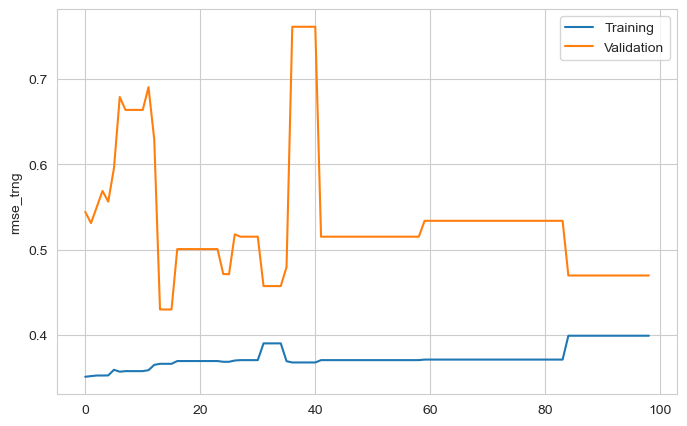

In [45]:
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(data=df, y='rmse_trng', x=df.index, label='Training')
sns.lineplot(data=df, y='rmse_val', x=df.index, label='Validation')
plt.show()

This gives us some really strong options. We see that some of the models were overparameterized --- the RMSE for validation was far worse than the RMSE for the training data. Let's find the model that had the lowest RMSE applied to the validation set.

In [46]:
df[df['rmse_val'] == df['rmse_val'].min()]

,formula,rmse_trng,rmse_val
13,I(np.log(MedHouseVal)) ~ MedInc + HouseAge + A...,0.36655,0.43017
14,I(np.log(MedHouseVal)) ~ MedInc + HouseAge + A...,0.36655,0.43017


From that information, we can use this model instead.

In [47]:
formula_minRMSE = form(13)

In [48]:
print(form(13))

I(np.log(MedHouseVal)) ~ MedInc + HouseAge + AveRooms + AveBedrms + Population + I(MedInc**2) + MedInc*AveRooms + MedInc*AveRooms*Population + I(HouseAge**2) + HouseAge*AveRooms*AveBedrms + I(AveRooms**2) + AveRooms*AveBedrms*Population + AveRooms*Population + I(AveBedrms**2) + I(Population**2) + I(AveOccup**2)


In [49]:
model = smf.ols(formula_minRMSE,Xy_train).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
==============================================================================
Model:                 OLS                     Adj. R-squared:      0.583     
Dependent Variable:    I(np.log(MedHouseVal))  AIC:                 11508.0466
Date:                  2022-11-21 16:34        BIC:                 11673.8045
No. Observations:      13828                   Log-Likelihood:      -5732.0   
Df Model:              21                      F-statistic:         920.5     
Df Residuals:          13806                   Prob (F-statistic):  0.00      
R-squared:             0.583                   Scale:               0.13436   
------------------------------------------------------------------------------
                               Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------------------
Intercept                     -0.7440   0.0611 -12.1747 0.0000 -0.8637 -0.6242
MedInc                         0.4910   0.0095  51.5019 0.0000  0.4723  0.5096
HouseAge                      -0.0054   0.0021  -2.5992 0.0094 -0.0095 -0.0013
AveRooms                      -0.1538   0.0105 -14.6209 0.0000 -0.1744 -0.1332
AveBedrms                      0.3765   0.0558   6.7467 0.0000  0.2671  0.4859
Population                    -0.0001   0.0000  -1.6445 0.1001 -0.0002  0.0000
I(MedInc ** 2)                -0.0235   0.0006 -40.7441 0.0000 -0.0247 -0.0224
MedInc:AveRooms                0.0028   0.0013   2.1951 0.0282  0.0003  0.0054
MedInc:Population             -0.0000   0.0000  -1.3917 0.1640 -0.0000  0.0000
AveRooms:Population           -0.0001   0.0000 -11.7096 0.0000 -0.0001 -0.0001
MedInc:AveRooms:Population     0.0000   0.0000   5.8318 0.0000  0.0000  0.0000
I(HouseAge ** 2)               0.0001   0.0000   6.3101 0.0000  0.0001  0.0002
HouseAge:AveRooms              0.0000   0.0002   0.0786 0.9373 -0.0004  0.0004
HouseAge:AveBedrms             0.0069   0.0016   4.2930 0.0000  0.0037  0.0100
AveRooms:AveBedrms            -0.0640   0.0097  -6.5778 0.0000 -0.0830 -0.0449
HouseAge:AveRooms:AveBedrms   -0.0003   0.0000  -7.4945 0.0000 -0.0003 -0.0002
I(AveRooms ** 2)               0.0095   0.0011   8.9344 0.0000  0.0074  0.0115
AveBedrms:Population           0.0003   0.0000   8.2551 0.0000  0.0002  0.0004
AveRooms:AveBedrms:Population  0.0000   0.0000   0.0329 0.9738 -0.0000  0.0000
I(AveBedrms ** 2)              0.1261   0.0232   5.4389 0.0000  0.0807  0.1715
I(Population ** 2)             0.0000   0.0000   3.8642 0.0001  0.0000  0.0000
I(AveOccup ** 2)              -0.0000   0.0000  -5.7316 0.0000 -0.0000 -0.0000
------------------------------------------------------------------------------
Omnibus:                 467.326          Durbin-Watson:             2.007    
Prob(Omnibus):           0.000            Jarque-Bera (JB):          1194.686 
Skew:                    0.136            Prob(JB):                  0.000    
Kurtosis:                4.414            Condition No.:             368384174
==============================================================================
* The condition number is large (4e+08). This might indicate
strong multicollinearity or other numerical problems.
"""

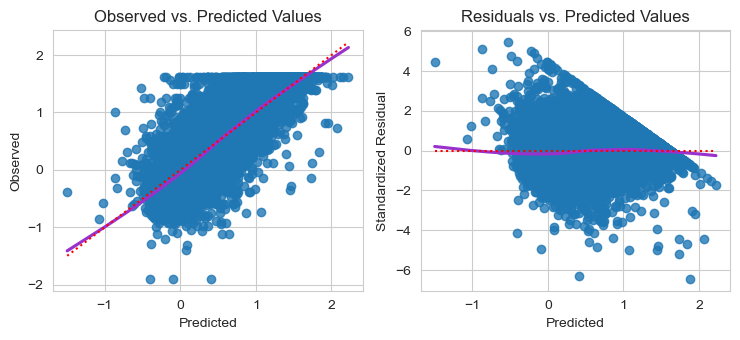

In [50]:
fig, ax = linearity_test(model,y_train['MedHouseVal'].apply(np.log))
fig.tight_layout()
plt.show()

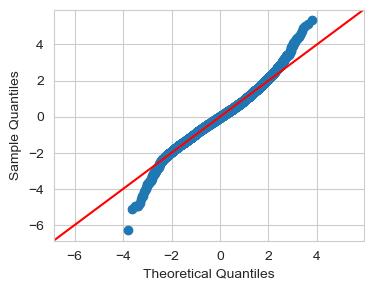

In [51]:
fig, ax = plt.subplots(figsize=(4,3))
smg.qqplot(model.resid, fit=True, line='45', ax=ax)
plt.show()

When we calculated RMSE for training and validation, we were actually doing that in the transformed y-space. Let's compare RMSE for training and validation after back-transforming, plus see how it compares to the RMSE for test data.

In [52]:
pred_trng = np.exp(model.fittedvalues)
rmse_trng = np.sqrt(mean_squared_error(y_train['MedHouseVal'], pred_trng))
print(rmse_trng)

0.7585979685364206


In [53]:
pred_val = np.exp(model.predict(X_val))
rmse_val = np.sqrt(mean_squared_error(y_val['MedHouseVal'], pred_val))
print(rmse_val)

0.7631055909418427


In [54]:
pred_test = np.exp(model.predict(X_test))
rmse_test = np.sqrt(mean_squared_error(y_test['MedHouseVal'], pred_test))
print(rmse_test)

0.8231617369070426


The test data fared worse than the training and validation data, but not drastically so. This is a pretty good outcome! Let's look at the performance on test data in more detail.

Text(0, 0.5, 'Observed Median House Value')

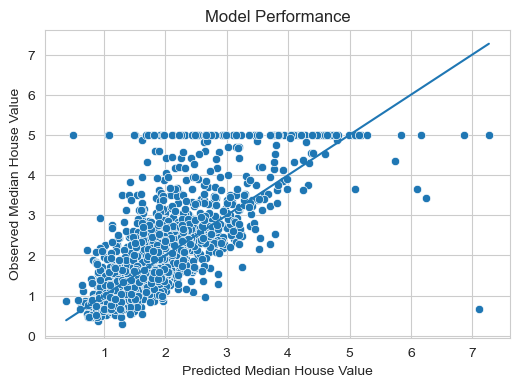

In [55]:
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(x=pred_test, y=y_test['MedHouseVal'], ax=ax)
sns.lineplot(x=pred_test, y=pred_test)
ax.set_title('Model Performance')
ax.set_xlabel('Predicted Median House Value')
ax.set_ylabel('Observed Median House Value')

Wow! Look at that outlier in the bottom-right. Let's examine that point.

In [56]:
X_test[(pred_test > 7) & (y_test['MedHouseVal'] < 5)]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
4548,7.5752,52.0,3.142857,1.0,55.0,7.857143


In [57]:
55/7.857143

6.999999872727275

In [58]:
pred_test[4548]

7.115723753480893

In [59]:
y_test.loc[4548]

MedHouseVal    0.675
Name: 4548, dtype: float64